In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 
# from statsmodels.graphics.tsaplots import plot_acf

In [2]:
path = "../data/final_tables/banc/banc.csv"
df = pd.read_csv(path)

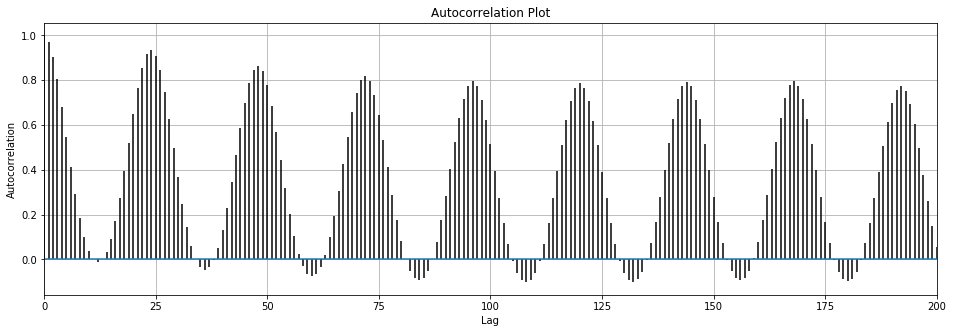

In [32]:
# Plotting the Autocorrelation plot.
data = df["Normalized Demand"]
lag=200
# Plot the autocorrelation
plt.figure(figsize=(16, 5))
plt.acorr(data, maxlags=lag, normed=True, usevlines=True)

# Adjust the plot to only show non-negative lags
plt.xlim([0, lag])

plt.title('Autocorrelation Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)

plt.show()

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from math import sqrt


class AR:
    def __init__(self, p):
        self.p = p
        self.model = LinearRegression()
        self.sigma = None

    def generate_train_x(self, data):
        # Number of rows in the output matrix
        rows = len(data) - self.p

        # Initialize the output matrix with ones
        # Each row will start with a 1, followed by p elements from the original array
        output_matrix = np.ones((rows, self.p + 1))

        for i in range(rows):
            # For each row, set the next p elements in reverse order starting from i+p
            output_matrix[i, 1:] = data[i : i + self.p][::-1]

        return output_matrix

    def generate_train_y(self, data):
        return data[self.p :]

    def fit(self, data):
        self.sigma = np.std(data)
        train_x = self.generate_train_x(data)
        train_y = self.generate_train_y(data)
        self.model.fit(train_x, train_y)

    def predict(self, data, num_preds):
        # Initialize the prediction set with the last p data points
        current_set = np.hstack(([1], data[-self.p :][::-1]))
        predictions = []

        for _ in range(num_preds):
            # Predict the next value
            next_pred = self.model.predict([current_set])[0]
            predictions.append(next_pred)

            # Update the current set for the next prediction
            current_set = np.hstack(([1], np.hstack((next_pred, current_set[1:-1]))))

        return predictions

    def validate(self, data, num_preds):
        rmses = []
        # Iterate through the data in steps of num_preds, starting from 0 up to len(data) - self.p - num_preds
        for i in range(0, len(data) - self.p - num_preds + 1, 100):
            # The current chunk to predict on
            current_chunk = data[i : i + self.p]
            # The actual future values to compare against
            actual_values = data[i + self.p : i + self.p + num_preds]
            # Predict the next num_preds values
            predictions = self.predict(current_chunk, num_preds)
            # Calculate RMSE for the current set of predictions
            rmse = sqrt(mean_squared_error(actual_values, predictions))
            rmses.append(rmse)
        # Calculate the average RMSE
        average_rmse = np.mean(rmses)
        return average_rmse


In [55]:
np.arange(2,9)

array([2, 3, 4, 5, 6, 7, 8])

loading data...
data loaded...
AR constructed. Fitting...
Fitted. Validating...
average rmse: 0.38461900561610884


/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/aidanwiteck/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional in

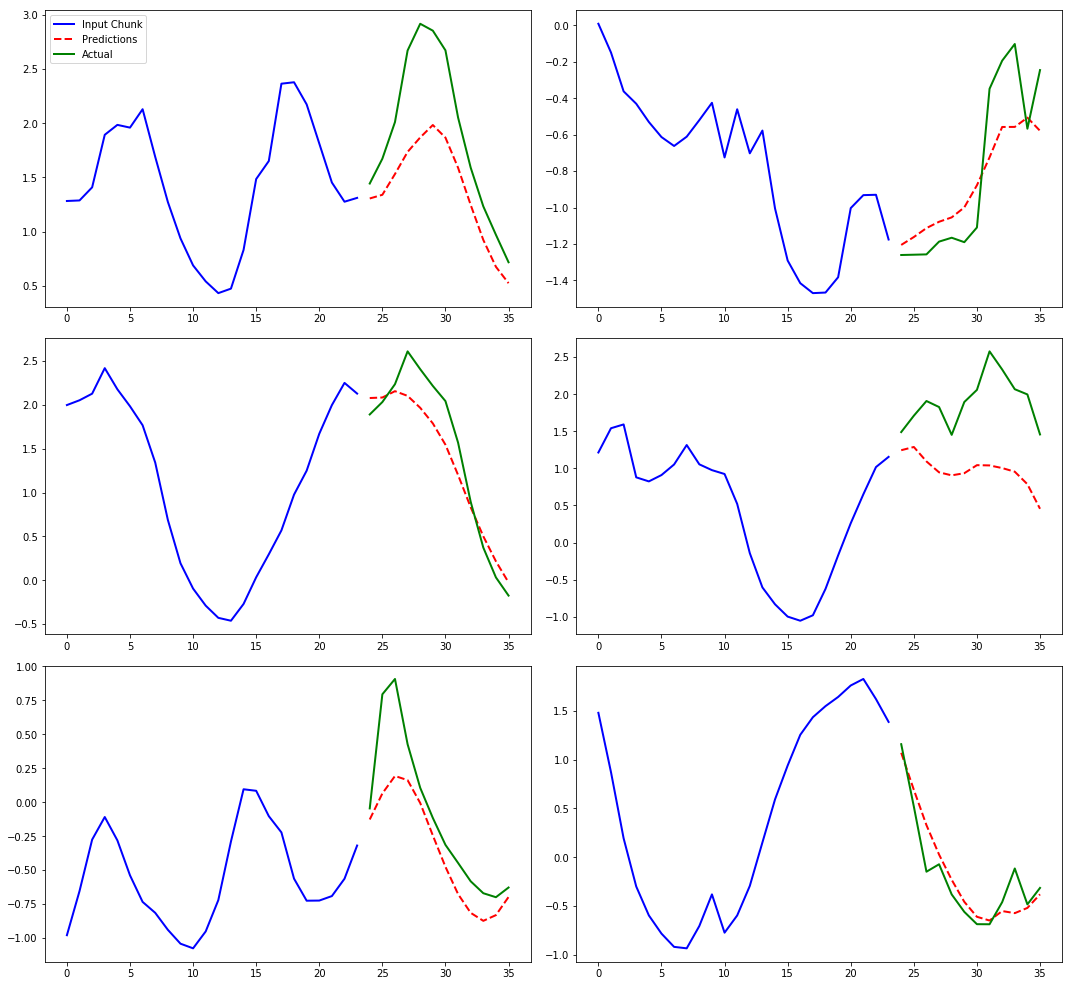

0.38461900561610884

In [57]:
def train_and_validate(path, p=24, num_preds=12,save=False):
    print("loading data...")
    df = pd.read_csv(path)
#     data = df["Normalized Demand"]
    data = df["load_normalized"]
    print("data loaded...")
    split = int(0.9 * len(data))
    data_train = data[:split]
    data_test = data[split:]

    ar = AR(p)
    print("AR constructed. Fitting...")
    ar.fit(data_train)
    print("Fitted. Validating...")
    rmse = ar.validate(data_test, num_preds=num_preds)
    print(f"average rmse: {rmse}")
    
    # Prepare the figure for a 3x2 subplot grid
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
#     fig.suptitle('AR Predictions vs. Actual Values', fontsize=16)
    x_list_input=np.arange(p)
    x_list_preds=np.arange(p,p+num_preds)
    for i in range(3):
        for j in range(2):
            start_point = random.randint(0, len(data_test) - p - num_preds)
            test_chunk = data_test[start_point:start_point + p]
            actual_following = data_test[start_point + p:start_point + p + num_preds]

            # Adjust for the flatten index in subplots
            ax = axs[i, j]

            # Predict the next few time steps
            predictions = ar.predict(test_chunk, num_preds)

            # Adjust x-axis values to visualize continuity and distinction between the sequences
            x_input = range(start_point, start_point + p)
            x_preds = range(start_point + p, start_point + p + num_preds)

            # Plotting on the respective subplot
            ax.plot(x_list_input, test_chunk, 'b-', label='Input Chunk' if i+j == 0 else "", linewidth=2)
            ax.plot(x_list_preds, predictions, 'r--', label='Predictions' if i+j == 0 else "", linewidth=2)
            ax.plot(x_list_preds, actual_following, 'g-', label='Actual' if i+j == 0 else "", linewidth=2)

            # Include labels/legend in the first subplot only to avoid redundancy
            if i == 0 and j == 0:
                ax.legend()

    # Optional: Adjust layout for better fit
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    if save:
        plt.savefig("/Users/aidanwiteck/Desktop/Princeton/Year 4/Thesis/Homeworks/SemesterReport/armodel_preds.pdf", format="pdf", bbox_inches="tight")
    plt.show()

    return rmse


path = "../data/final_tables/gefcom12/gefcom12.csv"
train_and_validate(path, save=True)